# 0 - Information

In [1]:
# Author: Pierre Oreistein
# Last edit: 06/06/2021

# 1 - Packages

## 1.1 - Mainstream Packages

In [103]:
# Maths packages
import numpy as np

# Data Handling Packages
import pandas as pd

# Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix

from xgboost.sklearn import XGBClassifier

# NLP Packages
import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from contractions import fix

# Graphics Packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Utils
import pprint
from colorama import Fore, Back, Style
from IPython.display import display, HTML
from tqdm import tqdm; tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

# Static Type Checking
from typing import List, Union

[nltk_data] Downloading package punkt to /home/poreistein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/poreistein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/poreistein/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.2 - Personnal Utils

In [40]:
class COLOR:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
def display_check(boolean: bool) -> str:
    """
    Display the boolean with color and bold for easier understanding.
    """
    # If the boolean is True
    if boolean:
        return COLOR.BOLD + Back.GREEN + "True" + Style.RESET_ALL
    else:
        return COLOR.BOLD + Back.RED + "False" + Style.RESET_ALL
    
def display_title(title: str) -> None:
    """Display title"""
    print(f"----- {COLOR.BOLD} {title} {Style.RESET_ALL} -----")
    
def display_dataframe(df: pd.DataFrame) -> None:
    """Pretty display inside Jupyter Notebook of DataFrames."""
    display(HTML(df.to_html()))

# 2 - Load Data and Global Parameters

## 2.1 - Load Data

In [41]:
# Load the data
train_raw_df = pd.read_csv("./Data/01_Raw_Data/train.csv")

# Display the raw data
display_dataframe(train_raw_df.head(5));

,id,l1_category_name,l2_category_name,l3_category_name,title,category_id,price
0,7f1f33cf-a59a-4114-8f9e-cf3effaa2341,Men's Fashion,Men's Watches,NaN,Fossil Leather Watch,20,100.56
1,88765cd5-3f53-403c-841a-12dc367843c9,Men's Fashion,Men's Watches,NaN,* FREE DELIVERY * JDM Brand New 100% Authentic Seiko Presage White Dial & Blue Hands Men's Automatic Dress Watch SARX033,20,1008.37
2,264e2900-ba35-4ac0-8858-e2fcb0909e6d,Men's Fashion,Men's Watches,NaN,St Dupont Classic Pen,20,220.31
3,ffc7337a-7d04-4fa8-a136-ac9d8413f8e8,Men's Fashion,Men's Watches,NaN,CASIO G-SHOCK GX-56BB-1DR / GX-56BB-1D / GX-56BB-1 / GX-56BB TOUGH SOLAR WATCH,20,104.95
4,34a2e32c-db54-4aff-b89d-173bacbac346,Men's Fashion,Men's Watches,NaN,Fossil Townsman Twist ME1164P,20,166.37


In [42]:
# Load the data
X_test_raw_df = pd.read_csv("./Data/01_Raw_Data/test.csv")

# Display the raw data
display_dataframe(X_test_raw_df.head(5))

,id,title,price
0,c90123c0-09a2-4d0d-8ddd-447cd12edd4a,Yeezy boost 350 V2 Core Black/Ref,402.41
1,e1dc8ac7-6a89-4ef9-a790-3f4d0835aaf7,Nakamichi Sports Bluetooth Earphones,44.93
2,520743b2-6c83-4ba9-98a2-3d2fff697fa2,Tefal Steam Cuisine 900 Turbo Diffusion,104.00
3,e5136110-bd9b-4011-81f3-de904d916c91,B5 Lofter High Gain Wireless USB Adapter 1200Mbps,21.64
4,a459aa14-7e28-4a95-8c98-690509c373db,Taiwan Customize Handmade APO Float,41.60


## 2.2 - Global Parameters

In [43]:
# Compute the number of classes
CLASSES_L = train_raw_df.category_id.unique()
NUM_CLASSES = len(CLASSES_L)

display_title("Number of classes to distinguish")
print(f"Number of classes to predict? {NUM_CLASSES}")
print("\n")

# Compute class weights
CLASS_WEIGHTS_L = compute_class_weight(
    class_weight="balanced",
    classes=CLASSES_L,
    y=train_raw_df.category_id.values
)
CLASS_WEIGHTS_DCT = {category_id: CLASS_WEIGHTS_L[i] for i, category_id in enumerate(CLASSES_L)}

display_title("Class Weights")
pprint.pprint(CLASS_WEIGHTS_DCT)
print("\n")

# Random state
RANDOM_STATE = 42

-----  Number of classes to distinguish  -----
Number of classes to predict? 26


-----  Class Weights  -----
{1: 0.6100051433823219,
 2: 0.844344852537843,
 3: 0.8675100425684993,
 4: 2.157842932561816,
 5: 0.6474784087349532,
 6: 0.5414025608597065,
 7: 2.433352393125021,
 8: 21.823831070889895,
 9: 1.9130549752756696,
 10: 7.675968169761274,
 11: 0.636809351536437,
 12: 0.3995030095532608,
 13: 4.113138893626698,
 14: 8.269059321065265,
 15: 0.5535737514251391,
 16: 0.3001335844610572,
 17: 17.445382204002893,
 18: 1.520097493328851,
 19: 9.90227210511908,
 20: 1.1154694173335185,
 21: 0.44205869593112423,
 22: 1.4931786753627376,
 23: 60.48996655518395,
 24: 1.325018315018315,
 25: 0.5705430513714295,
 26: 3.1782278258577517}




# 3 - Data Cleaning and Preparation

Comments
-----

Please find below our modelisation hypotheses and choices:
* Following our observations in the notebook "1-DATA-EXPLORATION", we will discard for simplicity for now the feature 'price' as it presents several difficulties (low information content, null values, extremely high values, etc)

## 3.1 - Data Cleaning and Preparation for Model Ingestion

In [44]:
def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the dataFrame and prepare it for model ingestion."""
    # Create a new copy of df
    new_df = df.copy(deep=True)
    
    # Set the column "id" as the index
    new_df.set_index("id", inplace=True)
    
    # Keep only the columns "category_id" if it exists and "title"
    # The column 'price' is dropped for now
    columns_to_drop_l = [col for col in new_df.columns if col not in ["title", "category_id"]]
    new_df.drop(columns=columns_to_drop_l, inplace=True)
    
    return new_df

In [45]:
# Preprocess the data for cleaning
train_df = data_preprocessing(train_raw_df)
X_test_df = data_preprocessing(X_test_raw_df)

# And save the preprocess dataframe
train_df.to_csv("./Data/02_Data_Features/train.csv")
X_test_df.to_csv("./Data/02_Data_Features/X_test.csv")

# Display the resulting dataFrames
display_dataframe(train_df.head(5))

,title,category_id
id,,
7f1f33cf-a59a-4114-8f9e-cf3effaa2341,Fossil Leather Watch,20
88765cd5-3f53-403c-841a-12dc367843c9,* FREE DELIVERY * JDM Brand New 100% Authentic Seiko Presage White Dial & Blue Hands Men's Automatic Dress Watch SARX033,20
264e2900-ba35-4ac0-8858-e2fcb0909e6d,St Dupont Classic Pen,20
ffc7337a-7d04-4fa8-a136-ac9d8413f8e8,CASIO G-SHOCK GX-56BB-1DR / GX-56BB-1D / GX-56BB-1 / GX-56BB TOUGH SOLAR WATCH,20
34a2e32c-db54-4aff-b89d-173bacbac346,Fossil Townsman Twist ME1164P,20


# 4 - Tokenization of the Sentences & Build Models Inputs

## 4.1 - Split the Training set into a training and a validation set

In [46]:
def prepare_model_training_inputs(
    df: pd.DataFrame,
    test_size: float=0.1,
    num_classes: int=NUM_CLASSES
) -> List[Union[pd.DataFrame, np.array]]:
    """Prepare model inputs."""
    # Divide the training set between a training and validation set
    X_train_df, y_train_df = df["title"], df["category_id"]
        
    # Split the training set into a training and validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_df,
        y_train_df,
        test_size=test_size,
        random_state=RANDOM_STATE,
        shuffle=True,
        stratify=y_train_df.values,   
    )   
    # Convert to dataFrames
    X_train_df = X_train.to_frame(name="title")
    X_val_df = X_val.to_frame(name="title")
    
    # Append the ground truth as a label
    X_train_df["label"] = y_train
    X_val_df["label"] = y_val
    
    return X_train_df, X_val_df

In [47]:
# Split the training set
X_train_df, X_val_df = prepare_model_training_inputs(train_df, test_size=0.1)

# Display resulting traning set
display_dataframe(X_train_df.head(5))

,title,label
id,,
4d084e8b-4209-4057-be73-62d04469db17,BNWT Superga Navy Sneakers,9
27d5392d-ef1d-4ca6-8951-7d87048541cd,Hollister,12
254fb7a2-fad6-44a8-a7de-4c4c2c3e0244,Jeffree star lip gloss midnight lick,11
b77f33f1-ba41-4b10-9577-e65c9d09852d,Etude House Powder Rouge Tint #MoreRed,11
fb6d1ab8-a4bd-4e93-b28c-5200b58452ee,WMF child’s set 4 pcs Teddy,16


In [48]:
display_dataframe(X_val_df.head(5))

,title,label
id,,
ce759da2-157b-4508-95c1-75141cc32cbc,Yeezy Boost 350 “Yecheil” Non Reflective,15
0f9957ea-d96c-4aaf-a5e7-8756767b9356,Music sight reading grade 4,22
7a14231b-e7a0-4973-a076-ef83f3a4eb7d,"Empire Ears EVR UIEM, BNIB",6
e13998d0-00a5-4abc-857c-112b3d61e53c,Commercial Microwave ( SG warranty / Commercial ) Brand New,16
18b196e7-33f0-442c-b322-b764934107f3,Mini Sinningia Pirate’s Skyline,18


In [49]:
display_dataframe(X_test_df.head(5))

,title
id,
c90123c0-09a2-4d0d-8ddd-447cd12edd4a,Yeezy boost 350 V2 Core Black/Ref
e1dc8ac7-6a89-4ef9-a790-3f4d0835aaf7,Nakamichi Sports Bluetooth Earphones
520743b2-6c83-4ba9-98a2-3d2fff697fa2,Tefal Steam Cuisine 900 Turbo Diffusion
e5136110-bd9b-4011-81f3-de904d916c91,B5 Lofter High Gain Wireless USB Adapter 1200Mbps
a459aa14-7e28-4a95-8c98-690509c373db,Taiwan Customize Handmade APO Float


## 4.2 - Tokenize and stemmization of the text

In [50]:
def preprocess_text(text: str) -> str:
    """Preprocess the text for the training."""
    # Check if the text if nan
    if text == np.nan:
        return [""]
    
    # 1 - Tokenization of the text
    tokens_l = word_tokenize(str(text))
    
    # 2 - Lowercase
    tokens_l = [w.lower() for w in tokens_l]
    
    # 3 - Remove stop words
    stop_words = set(stopwords.words(['english']))
    tokens_l = [w for w in tokens_l if not w in stop_words]
    
    # 4 - Expands contraction
    tokens_l = [fix(w) for w in tokens_l]
    
    # 5 - Lemmization
    lmr = WordNetLemmatizer()
    tokens_l = [lmr.lemmatize(w) for w in tokens_l]
    
    # 6 - Convert the list as a string
    final_text = " ".join(tokens_l)
    
    return final_text   

In [51]:
# Preprocess the text
X_train_df["title"] = X_train_df["title"].progress_apply(preprocess_text)
X_val_df["title"] = X_val_df["title"].progress_apply(preprocess_text)
X_test_df["title"] = X_test_df["title"].progress_apply(preprocess_text)

100%|██████████| 48560/48560 [00:13<00:00, 3472.22it/s]


# 5 - Model Fine Tuning

Comments
-----

## 5.1 - Fit a TF-IDF Model

In [72]:
X_train_df["title"].values

array(["[ 'bnwt ' , 'superga ' , 'navy ' , 'sneaker ' ]",
       "[ 'hollister ' ]",
       "[ 'jeffree ' , 'star ' , 'lip ' , 'gloss ' , 'midnight ' , 'lick ' ]",
       ...,
       "[ 'breville ' , 'bes840 ' , 'infuser ' , 'espresso ' , 'smart ' , 'grinder ' , 'pro ' ]",
       "[ 'barbie ' , 'shoe ' ]", "[ 'unisex ' , 'gshock ' ]"],
      dtype=object)

In [91]:
# For each sample count the presence of each word (token)
countVect = CountVectorizer()
X_train_counts = countVect.fit_transform(X_train_df["title"].values)

# Apply the TF-IDF transform
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 5.2 - Model Fitting: SVC

In [92]:
# Define the parameters of the GridSearch
params_dct = {
    "n_estimators": [300],
    "max_depth":[None],
    "min_samples_split": [10]
}

# params_dct = {
#     "n_estimators": [10, 50, 100],
#     "max_depth": [2, 5, 10],
#      "min_child_weight": [0, 1, 10],
# }

# Define the model: a Support Vector Classifier
rf = RandomForestClassifier(class_weight="balanced", n_jobs=2)
#rf = XGBClassifier(random_state=RANDOM_STATE)

# Define the GridSearch
clf = GridSearchCV(
    estimator=rf,
    param_grid=params_dct,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=4,
    refit=True,
    cv=2,
    verbose=10
    ,
)

## 5.3 - Model Training

In [93]:
clf.fit(X_train_tfidf, X_train_df["label"].values)
print("\n")

# Display score
display_title("Best Results")
print(f"Best balanced accuracy obtained: {clf.best_score_}")
print(f"Parameters of the best model: {clf.best_params_}")

Fitting 2 folds for each of 2 candidates, totalling 4 fits


-----  Best Results  -----
Best balanced accuracy obtained: 0.8013676595573023
Parameters of the best model: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}


# 6 - Analysis of the result

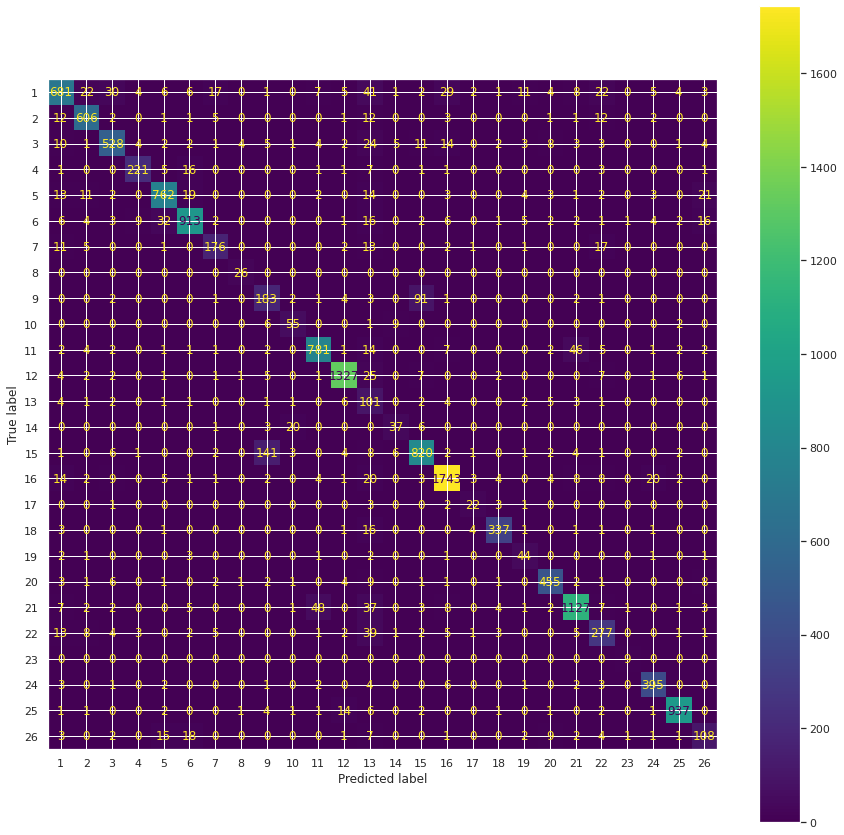

In [107]:
X_val = tfidf_transformer.transform(countVect.transform(X_val_df["title"].values))

fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, X_val, X_val_df["label"].values, ax=ax)

# 7 - Compute the Prediction

In [136]:
# Compute the prediction
X_test = tfidf_transformer.transform(countVect.transform(X_test_df["title"].values))
y_test = clf.predict_proba(X_test)

# Extract the top-3 for each prediction
y_test = np.argsort(y_test, axis=1)[:, -3:] + 1
y_test = np.flip(y_test, axis=1)

y_test_df = pd.DataFrame(y_test, index=X_test_df.index, columns=["Top-1", "Top-2", "Top-3"])

# Save the predictions
y_test_df.to_csv("./Data/05_Model_Outputs/y_test.csv")

# Save the predictions in the main folder
y_test_df.to_csv("y_test.csv")

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.64447308e-02 0.00000000e+00 0.00000000e+00 5.46997629e-04
 0.00000000e+00 0.00000000e+00 9.53008272e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
